In [1]:
# Imports
import numpy as np
np.set_printoptions(edgeitems=30, linewidth=100000)
import matplotlib as mpl
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from numpy.linalg import eigvalsh
import scipy.linalg as scl

from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [8]:
w1 = 5e9
w2 = 4.5e9
l1 = -300e6
l2 = -250e6

n1 = (np.arange(16) // 4)
n2 = np.array(list(range(4)) * 4)

In [9]:
def getHamiltonian(g: float) -> np.ndarray:
    # diagonal part
    H0 = np.diag(w1 * n1 + w2 * n2 + 0.5*(l1 * n1*(n1-1) + l2*n2*(n2-1)))
    #print(np.round(H0, 2) * 1e-9)
    
    # hopping
    Va = np.sqrt([0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9, 0])
    V = np.diag(Va, 3) + np.diag(Va, -3)
    #print(np.round(V, 2))
    
    # 2-photon (de-)excitation
    Vb = np.sqrt([1,2,3,0,2,4,6,0,3,6,9])
    V += np.diag(Vb, 5) + np.diag(Vb, -5)
    return H0 + g * V

def getEnergies(g: float) -> np.array:
    H = getHamiltonian(g)
    #print(2 * g**2 / (w1-w2))
    #print(evals)
    #print(evals - np.sort(np.diag(H0)))
    return eigvalsh(H)

In [10]:
# Create sorted labels
labels = [f"{i},{j}" for (i,j) in zip(n1, n2)]
evals = np.diag(getHamiltonian(0))
sortingIndices = np.argsort(evals)
sortedLabels = np.array(labels)[sortingIndices]
print(sortingIndices)

[ 0  1  4  2  5  8  3  6 12  9  7 10 13 11 14 15]


In [11]:
# Calculate eigenvalues of the Hamiltonian
couplings = np.linspace(0, 50e6, 100)
allEnergies = np.empty((16, 0)) #sorted by increasing value
for coupling in couplings:
    energies = getEnergies(coupling).reshape((16,1))
    allEnergies = np.append(allEnergies, energies, axis=1)

<IPython.core.display.Javascript object>


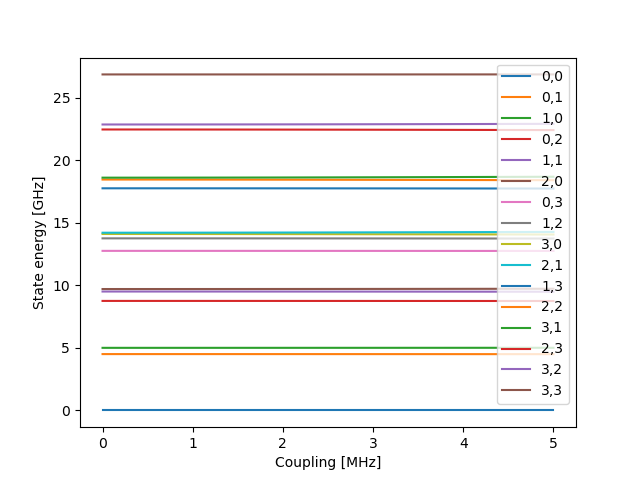

In [12]:
# Exact energy levels
plt.figure()
plt.plot(couplings / 1e7, allEnergies.T / 1e9)
plt.xlabel('Coupling [MHz]')
plt.ylabel('State energy [GHz]')
plt.legend(sortedLabels)
plt.show()

<IPython.core.display.Javascript object>


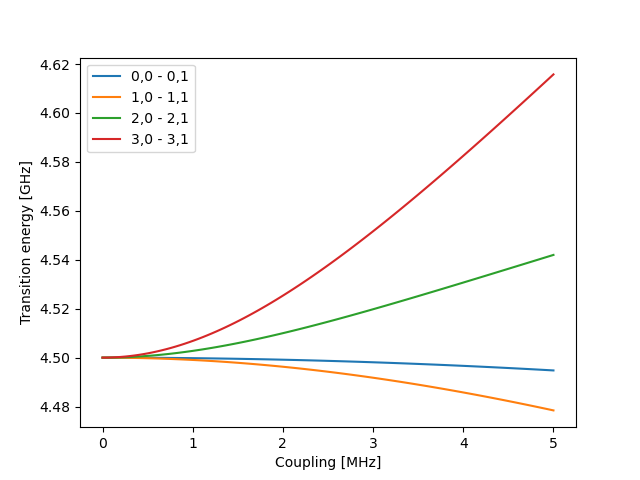

4.49806817512752
4.491628903808661
4.520103223979157
4.5525356794623715


In [21]:
# Exact transitions
plt.figure()

for i in range(16):
    for j in range(i+1, 16):
        diff = allEnergies[j] - allEnergies[i]
        if diff[0] > 4.4e9 and diff[0] < 4.6e9:
            plt.plot(couplings / 1e7, diff / 1e9, label=f"{sortedLabels[i]} - {sortedLabels[j]}")
            print(diff[60] / 1e9)
plt.xlabel('Coupling [MHz]')
plt.ylabel('Transition energy [GHz]')
plt.legend(loc='upper left')
plt.show()

In [ ]:
def ordersOfMagnitude(x: float) -> float:
    y = np.abs(x)
    order = 1
    if y == 0:
        order = 0
    elif y>1:
        order = 1
        while y>10:
            order += 1
            y /= 10
    elif y<1:
        order = -1
        while y<0.1:
            order -= 1
            y *= 10
    return order

In [ ]:
# Results from perturbation theory
allPerturbedEnergies = np.empty((16, len(couplings)))
delta = w1 - w2
wSum = w1 + w2
for idx in range(16):
    ni1 = n1[idx]
    ni2 = n2[idx]
    
    # 0th order
    E0 = w1*ni1 + w2*ni2
    if ni1 > 1:
        E0 += 0.5 * l1*ni1*(ni1-1)
    if ni2 > 1:
        E0 += 0.5 * l2*ni2*(ni2-1)
    
    # 2nd order
    Ediff = delta + l1 * ni1 - l2 * ni2
    E2 = 0
    if ni1 > 0 and ni2 < 3 and np.abs(Ediff - l1) > 1e-10:
        E2 += ni1 * (ni2 + 1) / (Ediff - l1)
    if ni1 < 3 and ni2 > 0 and np.abs(Ediff + l2) > 1e-10:
        E2 -= ni2 * (ni1 + 1) / (Ediff + l2)
    if ni1 > 0 and ni2 > 0 and np.abs(wSum + l1 * (ni1-1) + l2 * (ni2-1)) > 1e-10:
        E2 += ni1 * ni2 / (wSum + l1 * (ni1-1) + l2 * (ni2-1))
    if ni1 < 3 and ni2 < 3 and np.abs(wSum + l1 * ni1 + l2 * ni2) > 1e-10:
        E2 -= (ni1 + 1) * (ni2 + 1) / (wSum + l1 * ni1 + l2 * ni2)
    print(labels[idx], ni1, ni2, (ni1 > 0 and ni2 < 3), (ni1 < 3 and ni2 > 0), (ni1 > 0 and ni2 > 0), (ni1 < 3 and ni2 < 3))
    allPerturbedEnergies[idx] = E0 * np.ones_like(couplings) + couplings**2 * E2

print("State\tError\t\t\tMagnitude (error)")
for idx in range(16):
    error = allPerturbedEnergies[sortingIndices[idx], -1] - allEnergies[idx, -1]
    print(f"{sortedLabels[idx]}\t{error}\t{ordersOfMagnitude(error) - 9}")

In [ ]:
# Energy levels: comparison with perturbation theory
plt.figure()
for idx in range(10, 13):
    #if 4e9 < allEnergies[idx,0] < 5.5e9:
    line, = plt.plot(couplings / 1e7, allEnergies[idx] / 1e9, label=sortedLabels[idx])
    perturbedEnergies = allPerturbedEnergies[sortingIndices[idx]]
    plt.plot(couplings[::3] / 1e7, perturbedEnergies[::3] / 1e9, '.', label=None, c=line.get_color())
    #plt.plot(couplings / 1e7, perturbedEnergies / 1e9, ':')
plt.xlabel('Coupling [MHz]')
plt.ylabel('State energy [GHz]')
plt.legend()
plt.show()

In [ ]:
# Transitions: comparison with perturbation theory -> single hopping
fig = plt.figure()
ax = fig.gca()
for i in range(16):
    for j in range(i+1, 16):
        diff = allEnergies[j] - allEnergies[i]
        if diff[0] > 0e9 and diff[0] < 2.5e9:
        #if True:
            #colour = next(colours)
            line, = plt.plot(couplings / 1e7, diff / 1e9, label=f"{sortedLabels[i]} - {sortedLabels[j]}")
            perturbationDiff = allPerturbedEnergies[sortingIndices[j]] - allPerturbedEnergies[sortingIndices[i]]
            plt.plot(couplings[::3] / 1e7, perturbationDiff[::3] / 1e9, '.', label=None, c=line.get_color())
plt.xlabel('Coupling [MHz]')
plt.ylabel('Transition energy [GHz]')
plt.legend(loc='upper left')
#plt.grid()
plt.show()

In [2]:
w1 = 5e9
w2 = 4.5e9
l1 = -300e6
l2 = -250e6
g = 30e6

n1 = (np.arange(16) // 4)
n2 = np.array(list(range(4)) * 4)
t = 1

In [3]:
# diagonal part
H0 = np.diag(w1 * n1 + w2 * n2 + 0.5*(l1 * n1*(n1-1) + l2*n2*(n2-1)))
print(np.round(H0, 2) * 1e-9)

# hopping
Va = np.sqrt([0, 1, 2, 3, 0, 2, 4, 6, 0, 3, 6, 9, 0])
V = np.diag(Va, 3) + np.diag(Va, -3)
#print(np.round(V, 2))

# 2-photon (de-)excitation
Vb = np.sqrt([1,2,3,0,2,4,6,0,3,6,9])
V += np.diag(Vb, 5) + np.diag(Vb, -5)
V *= g
print(np.round(V * 1e-9, 2))

H = H0 + V
print(np.round(H * 1e-9, 3))

[[ 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    4.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    8.75  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.   12.75  0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    5.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    9.5   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.   13.75  0.    0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   17.75  0.    0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    9.7   0.    0.    0.    0.    0.    0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    0.    0.   14.2   0.    0.    0.    0.    0.    0.  ]
 [ 0.    0